# <h1><center> Data-mined Prediction of Tetrahedral Site Occupation in Inorganic Materials </center></h1>

- **Falll, 2019 Data Science 100 / 200 Final Project**
- **KyuJung Jun & Deep Dayaramani**

# 1. Introduction

<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Inorganic materials make up a large portion in functional materials, ranging from electrodes for battery applications, fast ionic conductors, semiconductors to thermoelectric materials. In the field of materials science, structure - property relationship is the core of most of materials design problems. Inevitably, in order to discover a novel material with a superb functional property, we tend to start from existing known crystal structures and dope them, or come up with a completely new structure that has not been reported. However, in both cases, the challenges that we face when we play with crystal structures and atomic positions is that we do not have a reliable way to quickly evaluate whether a certain structure with atomic configuration is stable or not. Although quantum mechanical calculations using density functional theory can accurately provide the energetics of a structure within ~ 1meV/atom scale, the cost is too high to be employed for high-throuput manner.

<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Given an anion framework, the site for cations to sit are usually limited to a few atomic positions where the positive charge of a cation is well surrounded by a number of anions to reduce the total energy. The most prevalent type of coordination in inorganic crystals are a *tetrahedral site* and an *octahedral site*. In these cases, the anions build a tetrahedron or an octahedron, and a cation sits in the center of the polyhedron to build this ionic crystal structure. According to previous studies by G. Hautier $^{1}$ and G. Ceder  $^{2}$, lithium atoms tend to occupy mostly tetrahedral and octahedral sites among a wide variety of coordination environments. 

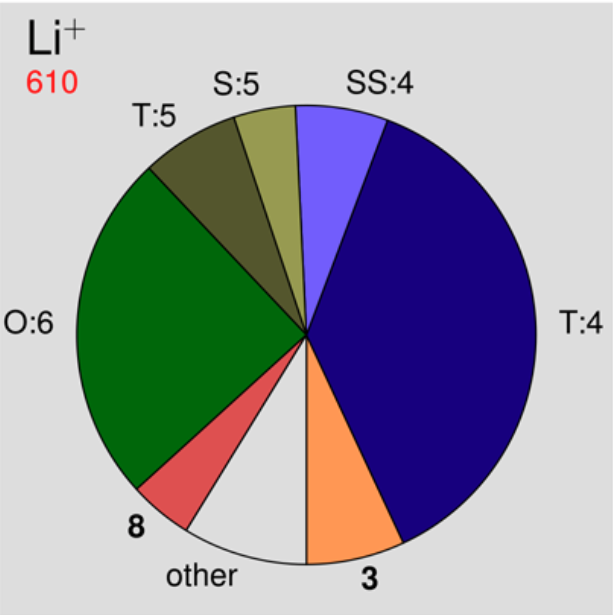
**Figure 1.** The statistical analysis of the coordination environments in Li-containing oxides. T:4 represents tetrahedral site and O:6 represents octahedral site. We can find that tetrahedral and octahedral sites occur more than 70% in the entire distribution.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Especially, in case of doping a certain element into a structure (even dilute doping case), the materials science community do not have a well defined rules that govern whether some dopants can be doped and other cannot. The issue of evaluating dopability is an important yet difficult problem in a wide range of materials design studies. Therefore, in this study, we aim to shed light on this *dopability* problem. Specifically, we pose the problem as follows. Restricting the cation of interest to only lithium, which is one of the most studied element for energy applications, and restricting the coordination environment of interest to only tetrahedral sites, we predict whether the lithium atom will occupy a given tetrahedral site turning it into a classification problem.

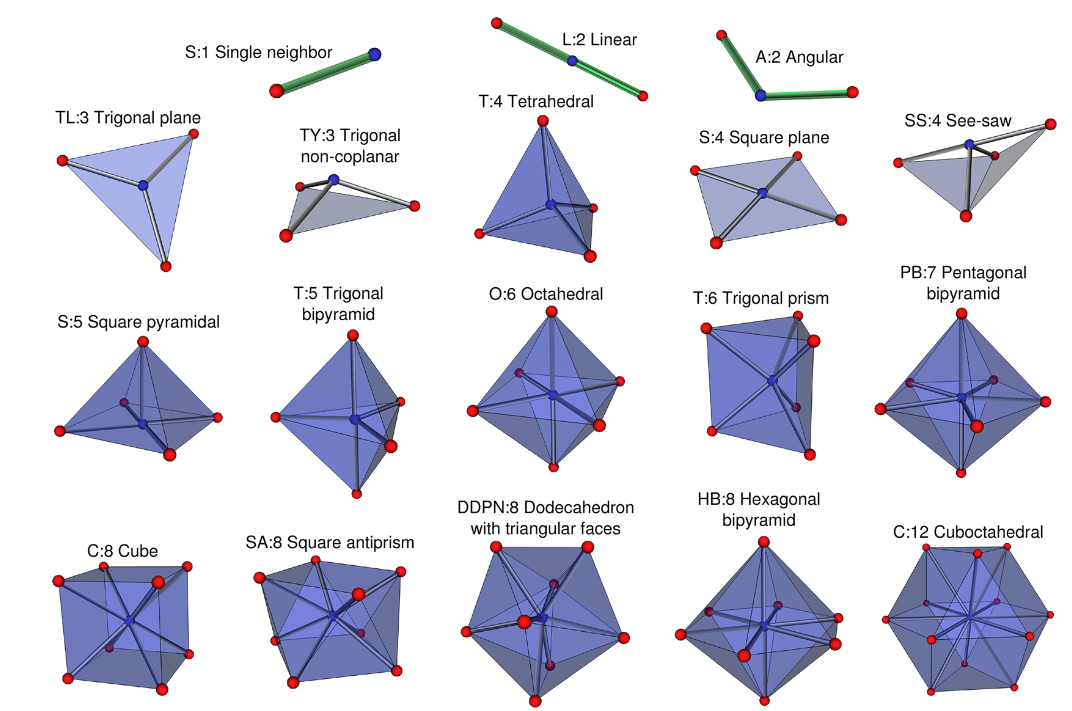
**Figure 2.** The standard symbol of various coordination environments $^{1}$. In this study, only the tetrahedral site is considered.

# 2. Method and Data Collection
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; We use the structures from the Materials Project database $^{3}$, a DFT-calculated database of all known inorganic crystal structures and a set of hypothetical structures. We collect all of the ternary lithium oxides allowing up to 50 meV/atom energy above hull. The reason for restricting only to ternary lithium oxides is because we want to directly observe the competition for a tetrahedral site between lithium and a non-lithium cation, which will be called X. By restricting up to 50 meV/atom, we can safely argue that these compounds have reasonablly stable site occupations. These ternary compounds are written as Li-X-O.
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The general structure analysis was performed using *pymatgen*$^{4}$ package and the coordination environment analysis was performed using specifically *chemenv*$^{5}$ module in *pymatgen*. The statistical analysis was performed using *scikit-learn* package.

In [4]:
#!pip install pymatgen

In [3]:
import numpy as np
import pandas as pd
import json
import os
import seaborn as sns
import numpy as np
from pymatgen.core import Structure
from pymatgen.ext.matproj import MPRester
from pymatgen.core.composition import *
from pymatgen.analysis.chemenv.coordination_environments.coordination_geometry_finder import LocalGeometryFinder
from pymatgen.analysis.chemenv.coordination_environments.structure_environments import LightStructureEnvironments
from pymatgen.analysis.chemenv.coordination_environments.chemenv_strategies import SimplestChemenvStrategy
from scipy.spatial import ConvexHull
from pymatgen.core.periodic_table import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as met
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

## 2.1 Data collection procedure
* Initial database : Materials project Ternary Li-oxides (Total of 1,830 structures to start with)
* After removing structures that have higher than 50 meV/atom above hull, we get 869 entries left.
* A portion of these 869 entries are removed based on the coordination environment analysis if:

(1) the structure does not contain any occupied tetrahedral site, regardless of the occupying element (Li or X)


(2) lithium atom occupy multiple kinds of coordination environments (we only want a single element to occupy a single kind of site by symmetry)

(3) the atom X occupy multiple kinds of coordination environments
<br>Then, we end up with a total of 156 ternary Li-oxides for modelling.

In [6]:
df = pd.read_pickle("Tetrahedral-Dataset_V4.pickle")

In [22]:
print(df.columns)

Index(['mpid', 'struct', 'formula', 'X_species', 'tet_li', 'tet_X',
       'Tetrahedral_Occupancy', 'Tetrahedral_Volume', 'Tet_CSM',
       'Competing_Volume', 'Competing_Environment', 'Competing_CSM',
       'X_charge', 'X Ionic Radius', 'X Atomic Radius', 'X Electronegativity',
       'competing_row', 'competing_group', 'competing_block'],
      dtype='object')


In [15]:
df.head()

,mpid,struct,formula,X_species,tet_li,tet_X,Tetrahedral_Occupancy,Tetrahedral_Volume,Tet_CSM,Competing_Volume,Competing_Environment,Competing_CSM,X_charge,X Ionic Radius,X Atomic Radius,X Electronegativity,competing_row,competing_group,competing_block
0,mp-1177528,"{'@module': 'pymatgen.core.structure', '@class...",Li3Ti7O14,Ti,"{'oct': [], 'tet': [{'csm': 0.0022241712812721...","{'oct': [{'csm': 0.6215316794802629, 'vol': 10...",Li,4.201175,0.001484,10.648055,oct,0.606701,3.571429,0.745,1.76,1.54,4,4,d
1,mp-976726,"{'@module': 'pymatgen.core.structure', '@class...",LiDyO2,Dy,"{'oct': [], 'tet': [{'csm': 1.601612267430422,...","{'oct': [{'csm': 0.521012997254456, 'vol': 16....",Li,4.160156,1.601607,16.077181,oct,0.521007,3.000000,1.052,2.28,1.22,8,12,f
2,mp-771290,"{'@module': 'pymatgen.core.structure', '@class...",LiMn2O4,Mn,"{'oct': [], 'tet': [{'csm': 0.1071326396070336...","{'oct': [{'csm': 0.5747060430678905, 'vol': 9....",Li,3.664453,1.060414,10.626605,oct,0.692949,3.500000,0.670,1.61,1.55,4,7,d
3,mp-772147,"{'@module': 'pymatgen.core.structure', '@class...",LiNb7O12,Nb,"{'oct': [{'csm': 28.007747747947796, 'vol': 10...","{'oct': [{'csm': 0.22608504681156708, 'vol': 1...",Nb,3.078004,9.909873,10.042085,oct,28.007748,3.285714,0.860,1.98,1.60,5,5,d
4,mp-772108,"{'@module': 'pymatgen.core.structure', '@class...",LiTi11O20,Ti,"{'oct': [], 'tet': [{'csm': 11.715618783359764...","{'oct': [{'csm': 0.5485547790999911, 'vol': 10...",Li,3.380015,11.715619,10.749769,oct,0.486442,3.545455,0.745,1.76,1.54,4,4,d


In [11]:
print("Number of data points: ", len(df))

Number of data points:  156


## 2.2 Feature extraction

1. Feature 1 : Volume of the tetrahedral site (unit in $\unicode{x212B}^3$)
2. Feature 2 : Volume of the competing site (e. g. octahedral sites) (unit in $\unicode{x212B}^3$) 
3. Feature 3 : Pauling's electronegativity value of X
4. Feature 4 : Ionic radius of X - Since we are focused on the competition between Li and other cation for a given tetrahedral site, this property is likely to be the most important feature. If the radius of element X is too large, then this would be difficult to occupy a tetrahedral site of a certain volume. On the other hand, if the radius of element X is too small, the energy will be higher (unstable) because the bonding of X-O is almost broken.
5. Feature 5 : Atomic radius of X - This will be less relevant than the ionic radius, but is still included. 
6. Feature 6 : Coordination symmetry measure (CSM) value of a tetrahedral site. The smaller the CSM value, the more symmetric the geometry is. CSM ranges from 0 to 100, 0 being perfectly symmetric and 100 being totally distorted.
7. Feature 7 : Coordination symmetry measure (CSM) value of a competing octahedral site.
8. Feature 8 : Element X
9. Feature 6 : Row of the element X in the periodic table. This can be done as one-hot encoding for different parts of periodic table, such as: "Is it a transition metal?", "Is it an Alkali metal?", "Is it an Alkali earth metal?", "Is it rare earth?".
11. Feature 11 : Column of the element X in the periodic table
12. Feature 12 : Block of the element X in the periodic table (s, p, d, f-block are the possibilities)

These features build up the design matrix.


The y vector should be made from the column "Tetrahedral Occupancy". Value "1" is assigned if this column value is "Li" (meaning that the tetrahedral site is occupied to lithium) and "0" if this column is not "Li" (meaning that another cation occupies the tetrahedral site in this structure). This is the variable that we aim to predict in this study.

The initial DataFrame object is saved into Tetrahedral-Dataset_V4.pickle file and is loaded into *df*.

## 2.3 Data Selection and Cleaning
In this part we first fill in the NaN values and find further information of the row and column numbers for X_species. As shown in the cell below, "X Atomic Radius" column have 5 missing points, so these are manually added.

In [12]:
df.isna().sum()

mpid                     0
struct                   0
formula                  0
X_species                0
tet_li                   0
tet_X                    0
Tetrahedral_Occupancy    0
Tetrahedral_Volume       0
Tet_CSM                  0
Competing_Volume         0
Competing_Environment    0
Competing_CSM            0
X_charge                 0
X Ionic Radius           0
X Atomic Radius          5
X Electronegativity      0
competing_row            0
competing_group          0
competing_block          0
dtype: int64

In [14]:
df[df['X Atomic Radius'].isna()]

,mpid,struct,formula,X_species,tet_li,tet_X,Tetrahedral_Occupancy,Tetrahedral_Volume,Tet_CSM,Competing_Volume,Competing_Environment,Competing_CSM,X_charge,X Ionic Radius,X Atomic Radius,X Electronegativity,competing_row,competing_group,competing_block
24,mp-760476,"{'@module': 'pymatgen.core.structure', '@class...",LiU3O8,U,"{'oct': [], 'tet': [{'csm': 26.858204923683832...","{'oct': [{'csm': 2.7079714287992984, 'vol': 12...",Li,0.876182,26.858205,12.746707,oct,2.984586,5.0,0.900,NaN,1.38,9,6,f
42,mp-8609,"{'@module': 'pymatgen.core.structure', '@class...",Li6UO6,U,"{'oct': [], 'tet': [{'csm': 4.581002814980115,...","{'oct': [{'csm': 0.5214358834590197, 'vol': 12...",Li,3.490418,4.581002,12.270320,oct,0.521436,6.0,0.870,NaN,1.38,9,6,f
91,mp-1020057,"{'@module': 'pymatgen.core.structure', '@class...",LiLaO2,La,"{'oct': [], 'tet': [{'csm': 3.1962162781159327...","{'oct': [{'csm': 5.61858859069598, 'vol': 17.9...",Li,4.019812,3.196216,17.920330,oct,5.618589,3.0,1.172,NaN,1.10,8,3,f
108,mp-8412,"{'@module': 'pymatgen.core.structure', '@class...",LiCeO2,Ce,"{'oct': [], 'tet': [{'csm': 3.558608219981555,...","{'oct': [{'csm': 6.522500251220635, 'vol': 16....",Li,3.769153,3.558608,16.406546,oct,6.522500,3.0,1.150,NaN,1.12,8,4,f
148,mp-756544,"{'@module': 'pymatgen.core.structure', '@class...",LiLaO2,La,"{'oct': [], 'tet': [{'csm': 7.20535497899418, ...","{'oct': [{'csm': 4.880895797653712, 'vol': 18....",Li,4.976217,7.205355,18.056858,oct,4.880896,3.0,1.172,NaN,1.10,8,3,f


Filling in values of atomic radii

In [21]:
df.loc[108,'X Atomic Radius'] = 2.48
df.loc[148,'X Atomic Radius'] = 2.50
df.loc[91,'X Atomic Radius'] = 2.50
df.loc[24,'X Atomic Radius'] = 2.30
df.loc[42,'X Atomic Radius'] = 2.30
df.isna().sum()

mpid                     0
struct                   0
formula                  0
X_species                0
tet_li                   0
tet_X                    0
Tetrahedral_Occupancy    0
Tetrahedral_Volume       0
Tet_CSM                  0
Competing_Volume         0
Competing_Environment    0
Competing_CSM            0
X_charge                 0
X Ionic Radius           0
X Atomic Radius          0
X Electronegativity      0
competing_row            0
competing_group          0
competing_block          0
dtype: int64

#### Here, we create the y column ("Li"), which tells us about the tetrahedral site is occupied by Li atom or not. Then we create the final_df with the rows we will use for the training and testing data

In [48]:
df['Li'] =[1 if df['Tetrahedral_Occupancy'][i]=='Li' else 0 for i in range(len(df))]

In [49]:
final_occ = df[['X_species','Tetrahedral_Volume','Tet_CSM','Competing_Volume','X_charge','Competing_CSM','X Ionic Radius','X Atomic Radius','X Electronegativity','competing_row','Li']]

In [50]:
final_occ['rounded_charge']= final_occ['X_charge'].apply(round)

/Users/kjun/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Thanks to Goodman Sciences, we got a csv containing data regarding the Periodic Table of Elements. We used this to include the row, column and type for the element X

In [51]:
periodic_table = pd.read_csv('Periodic Table of Elements.csv')

In [52]:
periodic_table_alt = periodic_table[['Symbol','Period','Group','Type']]
periodic_table_alt = periodic_table_alt.rename(columns ={'Symbol':'X_species'})
periodic_table_alt.head(6)

,X_species,Period,Group,Type
0,H,1,1.0,Nonmetal
1,He,1,18.0,Noble Gas
2,Li,2,1.0,Alkali Metal
3,Be,2,2.0,Alkaline Earth Metal
4,B,2,13.0,Metalloid
5,C,2,14.0,Nonmetal


In [53]:
final_occ_alt = pd.merge(final_occ,periodic_table_alt, on='X_species',how='inner')

The next cell includes an assumption for the f-block elements which don't have a group number but transitions from the s-block to the d-block elements

In [54]:
indexing = final_occ_alt[final_occ_alt['Group'].isna()]['Group'].index
final_occ_alt.loc[indexing, 'Group'] = 3.5

We one-hot encoded for the type of material X is from Halogen, Actinide, Lanthanide, Metalloid, Metal or Non-Metal

In [55]:
dummy = pd.get_dummies(final_occ_alt['Type'],drop_first=True)
final_occ_alt = pd.concat([final_occ_alt,dummy],axis=1)

In [57]:
final_occ_alt.columns

Index(['X_species', 'Tetrahedral_Volume', 'Tet_CSM', 'Competing_Volume',
       'X_charge', 'Competing_CSM', 'X Ionic Radius', 'X Atomic Radius',
       'X Electronegativity', 'competing_row', 'Li', 'rounded_charge',
       'Period', 'Group', 'Type', 'Halogen', 'Lanthanide', 'Metal',
       'Metalloid', 'Nonmetal', 'Transition Metal'],
      dtype='object')

#### We perform test-train split of 4:1 ratio. The training is performed on 124 datapoints and the testing is performed on 32 datapoints.

In [59]:
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(
    final_occ_alt, train_size=0.8, test_size=0.2, random_state=1)
print('Train:', train.shape, 'Test:', test.shape)

Train: (124, 21) Test: (32, 21)


# 3. Modelling Result
## 3.1 Initial model and identification of irrelevant features

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Using the design matrix, we model the system using logistic regression. L1 error function is used. We have a total of 15 features in the first model. By using the L1 error function, we were able to identify the features that are not relevant in the prediction.

In [92]:
num_vars = ['Tetrahedral_Volume','Tet_CSM', 'Competing_Volume', 'Competing_CSM', 'X_charge','X Ionic Radius','X Atomic Radius','X Electronegativity','competing_row','Halogen','Lanthanide','Metal','Metalloid','Nonmetal','Transition Metal']
def design_matrix(t, variables):
    """Create a design matrix from dataframe t."""
    scaled = t[variables]
    return scaled
design_matrix(train, num_vars).iloc[0,:]

Tetrahedral_Volume      3.156672
Tet_CSM                 9.890780
Competing_Volume       13.651057
Competing_CSM           0.594354
X_charge                3.416667
X Ionic Radius          0.860000
X Atomic Radius         1.980000
X Electronegativity     1.600000
competing_row           5.000000
Halogen                 0.000000
Lanthanide              0.000000
Metal                   0.000000
Metalloid               0.000000
Nonmetal                0.000000
Transition Metal        1.000000
Name: 66, dtype: float64

In [79]:
clf = LogisticRegression(fit_intercept=True, penalty='l1')
model = clf.fit(design_matrix(train, num_vars), train['Li'])
clf.predict(design_matrix(test, num_vars))

/Users/kjun/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### The result of the initial model is as follows.
* Training accuracy of 0.9032
* Test accuracy of 0.9375

In [80]:
test_accuracy = met.accuracy_score(test['Li'], clf.predict(design_matrix(test, num_vars)))
training_accuracy = met.accuracy_score(train['Li'], model.predict(design_matrix(train, num_vars)))
print("Training Accuracy: ", training_accuracy)
print("Test Accuracy: ", test_accuracy)

Training Accuracy:  0.9032258064516129
Test Accuracy:  0.9375


#### By observing the coefficients of the first model, we find that there are 6 features that have *0* coefficient, which indicates that these features are not relevant in predicting the occupation probability. These features are as follows:
* Ionic Radius of X
* (One-Hot) Halogen
* (One-Hot) Lanthanide
* (One-Hot) Metalloid
* (One-Hot) Non-metal
* (One-Hot) Transition Metal
<br><br>
Based on this observation, we find that the one-hot encoding of the block information is not significant in the prediction. One surprising point is that the ionic radius of X, which was expected to be the most significant feature has a zero coefficient. The reason behind this expectation is because these are all oxides. By having the only anion as oxygen, the ionicity of the Li-O bond and X-O bond is expected to be higher than covalency. However, our result may be due to the fact that we also include atomic radius of X as well. Therefore, in the next step, we investigate whether atomic radius is more significant in the prediction, or the ionic radius is more significant by building two distinct models using one of these features.

In [71]:
print(clf.coef_)
print(design_matrix(train).loc[0,:])

[[ 2.58365277  0.22585421 -0.17719836 -0.03561291 -0.39082963  0.
  -2.66503767 -1.22493576  0.45041747  0.          0.         -0.22959639
   0.          0.          0.        ]]
Tetrahedral_Volume      4.201175
Tet_CSM                 0.001484
Competing_Volume       10.648055
Competing_CSM           0.606701
X_charge                3.571429
X Ionic Radius          0.745000
X Atomic Radius         1.760000
X Electronegativity     1.540000
competing_row           4.000000
Halogen                 0.000000
Lanthanide              0.000000
Metal                   0.000000
Metalloid               0.000000
Nonmetal                0.000000
Transition Metal        1.000000
Name: 0, dtype: float64


### Case1 : Modeling with only the ionic radius of X
By excluding the "atomic radius of X" column, we achieve the following metrics.
* Training accuracy : 0.89516
* Test accuracy : 0.9375

In [98]:
only_ionic = ['Tetrahedral_Volume','Tet_CSM', 'Competing_Volume', 'Competing_CSM', 'X_charge','X Ionic Radius','X Electronegativity','competing_row','Halogen','Lanthanide','Metal','Metalloid','Nonmetal','Transition Metal']
clf_ionic = LogisticRegression(fit_intercept=True, penalty='l1')
model_ionic = clf_ionic.fit(design_matrix(train, only_ionic), train['Li'])
test_accuracy_ionic = met.accuracy_score(test['Li'], clf_ionic.predict(design_matrix(test, only_ionic)))
training_accuracy_ionic = met.accuracy_score(train['Li'], model_ionic.predict(design_matrix(train, only_ionic)))
print("Training Accuracy: ", training_accuracy_ionic)
print("Test Accuracy: ", test_accuracy_ionic)

Training Accuracy:  0.8951612903225806
Test Accuracy:  0.9375


/Users/kjun/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Case2 : Modelling with only the atomic radius of X
By excluding the "ionic radius of X" column, we achieve the following metrics.
* Training accuracy : 0.90322
* Test accuracy : 0.9375
<br>
For these reasons, we decide to keep only the atomic radius of X and drop the ionic radius column. The physical reason for this can be the fact that the ionic radius differs significantly based on the charge state of the cation. However, here, we simply use the ionic radius that is averaged over all possible charge states and this may lead to slightly lower performance. Still, considering the fact that our dataset is not very large, the performance difference between ionic radius and atomic radius information is small.

In [104]:
only_atomic = ['Tetrahedral_Volume','Tet_CSM', 'Competing_Volume', 'Competing_CSM', 'X_charge','X Atomic Radius','X Electronegativity','competing_row','Halogen','Lanthanide','Metal','Metalloid','Nonmetal','Transition Metal']
clf_atomic = LogisticRegression(fit_intercept=True, penalty='l1')
model_atomic = clf_atomic.fit(design_matrix(train, only_atomic), train['Li'])
test_accuracy_atomic = met.accuracy_score(test['Li'], clf_atomic.predict(design_matrix(test, only_atomic)))
training_accuracy_atomic = met.accuracy_score(train['Li'], model_atomic.predict(design_matrix(train, only_atomic)))
print("Training Accuracy: ", training_accuracy_atomic)
print("Test Accuracy: ", test_accuracy_atomic)

Training Accuracy:  0.9032258064516129
Test Accuracy:  0.9375


/Users/kjun/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Case3 : Modelling without the one-hot encoding of the block information
As identified above, the one-hot encoding of the block information had many zero-coefficients. Therefore, here these columns are excluded and the "Group" information, which contains the block information as well, is added. By removing all of the block information, the same testing and training accuracy is maintained.

In [112]:
noblock = ['Tetrahedral_Volume','Tet_CSM', 'Competing_Volume', 'Group','Competing_CSM', 'X_charge','X Atomic Radius','X Electronegativity','competing_row']
clf_block = LogisticRegression(fit_intercept=True, penalty='l1')
model_block = clf_block.fit(design_matrix(train, noblock), train['Li'])
test_accuracy_block = met.accuracy_score(test['Li'], clf_block.predict(design_matrix(test, noblock)))
training_accuracy_block = met.accuracy_score(train['Li'], model_block.predict(design_matrix(train, noblock)))
print("Training Accuracy: ", training_accuracy_block)
print("Test Accuracy: ", test_accuracy_block)

Training Accuracy:  0.9032258064516129
Test Accuracy:  0.9375


/Users/kjun/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## 3.2 Performance of our modified logistic regression model
In this section, the performance of our logistic regression model, excluding the irrelevant features is assessed.

In [119]:
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized confusion matrix"
    else:
        title = 'Confusion matrix, without normalization'

    print(cm)
    classes = ['Other','Li']    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title, y=1.3)

In [120]:
def evaluate(model, test_features, test_labels):
    y_pred = model.predict(test_features)
    y_test = test_labels
    cnf_matrix = met.confusion_matrix(y_test, y_pred)
    accuracy = met.accuracy_score(y_test,y_pred)
    precision = met.precision_score(y_test,y_pred)
    recall = met.recall_score(y_test,y_pred)
    plot_confusion_matrix(cnf_matrix)
    print('Model Performance')
    print('Precision is')
    print(precision)
    print('Accuracy is')
    print(accuracy)
    print('Recall is')
    print(recall)
    return accuracy

[[ 2  2]
 [ 0 28]]
Model Performance
Precision is
0.9333333333333333
Accuracy is
0.9375
Recall is
1.0


0.9375

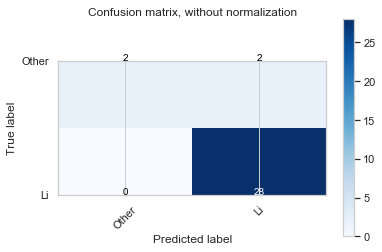

In [121]:
evaluate(clf_block,design_matrix(test,noblock),test['Li'])

## 3.3 Random Forest Classifier


* The function design_matrix is changed so that you input both the dataframe and the variables you want to include. From this section on, I think you can use the clf_block for the model, noblock for the list of relevant features.
* Could you please write this section for random forest?
* Also, for the section 3.2 model evaluation, wouldn't it be better to do cross-validation rather than just test / training set accuracy? LMK your opinion.
* For section 3.3 you can just write about the performance and implementation of the random forest classifier.
* For section 3.4, how about comparing the performance of random forest and logistic reg. in terms of accuracy / precision recall?
* For the random forest, it may be better to not let the tre
* Finally, if we can add another unsupervised learning, how about we do clustering of all of the datapoints using the same design matrix? By doing this, I'm pretty sure we will be able to directly see the periodic table clustering, which may be an interesting discussion point as well.
* Once you are done with these, I will write the discussion / conclusion section and finalize it.
* The random forest image is very good to include!!
* Please lmk and feel free to edit the beginning part. I think it's most important to let the TA / professors know why this problem is important, so I put some effort into that.
* LMK if you have any additional figures (from other references) that we may add!
* Thanks buddy! You are great!!

In [29]:
clf_forest = RandomForestClassifier(n_estimators=10)

In [30]:
clf_forest.fit(design_matrix(train),train['Li'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
met.accuracy_score(test['Li'],clf_forest.predict(design_matrix(test))), met.accuracy_score(train['Li'],clf_forest.predict(design_matrix(train)))

(1.0, 0.9919354838709677)

[[ 4  0]
 [ 0 28]]
Model Performance
Precision is
1.0
Accuracy is
1.0
Recall is
1.0


1.0

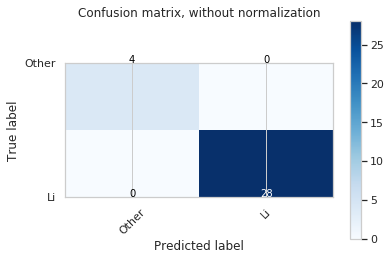

In [32]:
evaluate(clf_forest,design_matrix(test),test['Li'])

In [33]:
design_matrix(train).columns

Index(['Tetrahedral_Volume', 'Tet_CSM', 'Competing_Volume', 'X_charge',
       'X Ionic Radius', 'X Atomic Radius', 'X Electronegativity',
       'competing_row', 'Halogen', 'Lanthanide', 'Metal', 'Metalloid',
       'Nonmetal', 'Transition Metal'],
      dtype='object')

In [34]:
estimator = clf_forest.estimators_[6]
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = design_matrix(train).columns,
                class_names = 'YN',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

(1) D. Waroquiers, G. Hautier et al., *Statistical analysis of coordination environments in oxides*, Chemistry of Materials, 2017.


(2) G. Hautier, G. Ceder et al., *Data Mined Ionic Substitutions for the Discovery of New Compounds*, Inorganic Chemistry, 2011.